In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import lstm
import torch.nn as nni


df = pd.read_csv('internet_usage.csv')
df.head()



,Country Name,Country Code,2000,2001,2002,2003,2004,2005,2006,2007,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Afghanistan,AFG,..,0.00472257,0.0045614,0.0878913,0.105809,1.22415,2.10712,1.9,...,7,8.26,11,13.5,16.8,17.6,18.4,..,..,..
1,Albania,ALB,0.114097,0.325798,0.390081,0.9719,2.42039,6.04389,9.60999,15.0361,...,54.3,56.9,59.6,62.4,65.4,68.5504,72.2377,79.3237,82.6137,83.1356
2,Algeria,DZA,0.491706,0.646114,1.59164,2.19536,4.63448,5.84394,7.37598,9.45119,...,29.5,38.2,42.9455,47.6911,49.0385,58.9776,60.6534,66.2356,71.2432,..
3,American Samoa,ASM,..,..,..,..,..,..,..,..,...,..,..,..,..,..,..,..,..,..,..
4,Andorra,AND,10.5388,..,11.2605,13.5464,26.838,37.6058,48.9368,70.87,...,86.1,87.9,89.7,91.5675,..,90.7187,93.2056,93.8975,94.4855,..


In [2]:
df.shape

(217, 26)

In [3]:



df.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Country Name  217 non-null    object
 1   Country Code  217 non-null    object
 2   2000          217 non-null    object
 3   2001          217 non-null    object
 4   2002          217 non-null    object
 5   2003          217 non-null    object
 6   2004          217 non-null    object
 7   2005          217 non-null    object
 8   2006          217 non-null    object
 9   2007          217 non-null    object
 10  2008          217 non-null    object
 11  2009          217 non-null    object
 12  2010          217 non-null    object
 13  2011          217 non-null    object
 14  2012          217 non-null    object
 15  2013          217 non-null    object
 16  2014          217 non-null    object
 17  2015          217 non-null    object
 18  2016          217 non-null    object
 19  2017    

/var/folders/4q/4w3g7t5n0td3xk6v5zqfpp2w0000gn/T/ipykernel_56237/3940635845.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_countries[col] = pd.to_numeric(selected_countries[col].replace('..', np.nan), errors='coerce')


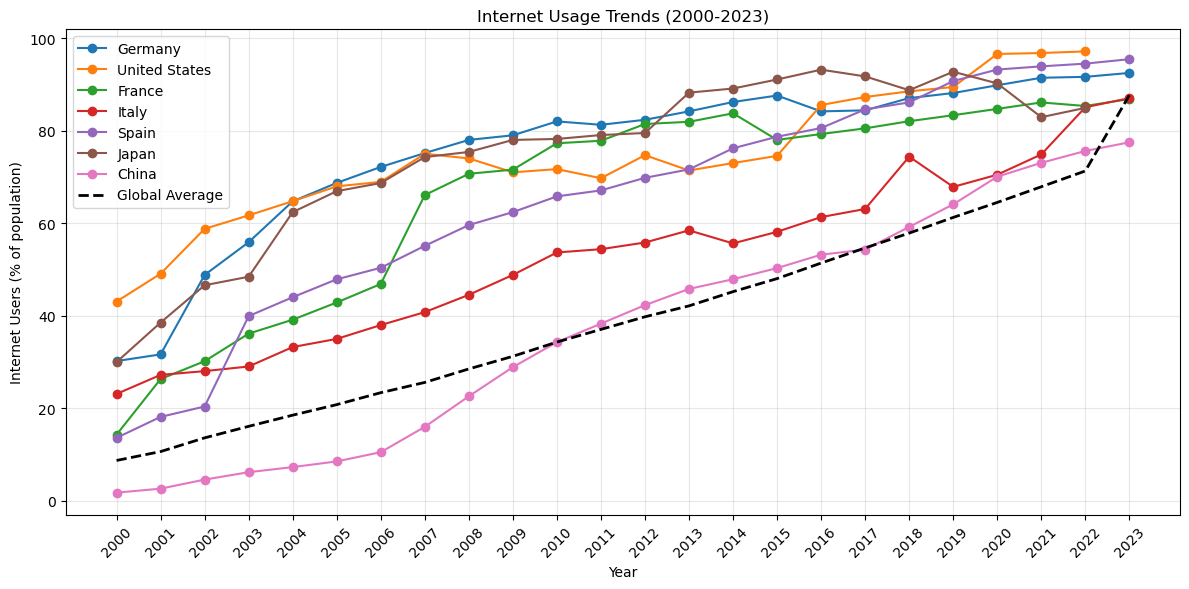

In [4]:
# plot a few similar ecomoies (germany, usa, france, italy, spain, japan, china)

# Select countries of interest
countries = ['Germany', 'United States', 'France', 'Italy', 'Spain', 'Japan', 'China']
selected_countries = df[df['Country Name'].isin(countries)]

# Convert year columns to numeric, replacing '..' with NaN
year_columns = [str(year) for year in range(2000, 2024)]
for col in year_columns:
    selected_countries[col] = pd.to_numeric(selected_countries[col].replace('..', np.nan), errors='coerce')

# Calculate global average
global_avg = df.copy()
for col in year_columns:
    global_avg[col] = pd.to_numeric(global_avg[col].replace('..', np.nan), errors='coerce')
global_avg = global_avg[year_columns].mean()

# Transpose the data for plotting
plot_data = selected_countries.set_index('Country Name')[year_columns].T

# Create the plot
plt.figure(figsize=(12, 6))
for country in countries:
    plt.plot(plot_data.index, plot_data[country], marker='o', label=country)

# Add global average line
plt.plot(global_avg.index, global_avg.values, 'k--', linewidth=2, label='Global Average')

plt.title('Internet Usage Trends (2000-2023)')
plt.xlabel('Year')
plt.ylabel('Internet Users (% of population)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
def preprocess_to_time_series(df, countries=None, max_missing_pct=0.5):
    """
    Convert country internet usage data to time series format and filter out countries
    with too many missing values.
    
    Args:
        df: DataFrame with country internet usage data
        countries: List of specific countries to include (None for all)
        max_missing_pct: Maximum percentage of missing values allowed per country
        
    Returns:
        time_series_df: Pandas DataFrame with years as index and countries as columns
    """
    # Replace '..' with NaN
    df = df.replace('..', np.nan)
    
    # Extract year columns
    year_columns = [str(year) for year in range(2000, 2024)]
    
    # Convert to numeric values
    for col in year_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Filter to selected countries if provided
    if countries is not None and len(countries) > 0:
        df = df[df['Country Name'].isin(countries)]
    
    # Create a new DataFrame with years as index and countries as columns
    time_series_data = {}
    
    for _, row in df.iterrows():
        country = row['Country Name']
        country_data = row[year_columns]
        
        # Count missing values using pandas isnull()
        missing_count = pd.isnull(country_data).sum()
        
        # Only include countries with sufficient data
        if missing_count <= len(year_columns) * max_missing_pct:
            time_series_data[country] = country_data.values
    
    # Create the time series DataFrame
    time_series_df = pd.DataFrame(time_series_data, index=[int(year) for year in year_columns])
    
    return time_series_df

In [6]:
time_series_df = preprocess_to_time_series(df)

time_series_df

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,...,Uruguay,Uzbekistan,Vanuatu,"Venezuela, RB",Viet Nam,Virgin Islands (U.S.),West Bank and Gaza,"Yemen, Rep.",Zambia,Zimbabwe
2000,NaN,0.114097,0.491706,10.5388,0.105046,6.48223,7.03868,1.30047,15.4428,46.7561,...,10.5391,0.484347,2.10834,3.3596,0.254248,13.8151,1.11131,0.0825,0.191072,0.401434
2001,0.004723,0.325798,0.646114,NaN,0.136014,8.89929,9.78081,1.63109,17.1,52.6893,...,11.1214,0.597568,2.83057,4.636,1.26565,18.3758,1.83685,0.090802,0.23313,0.799846
2002,0.004561,0.390081,1.59164,11.2605,0.270377,12.5,10.8821,1.96041,18.8,NaN,...,11.4195,1.08194,3.51004,4.91045,1.855,27.4944,3.10009,0.518796,0.477751,1.1
2003,0.087891,0.9719,2.19536,13.5464,0.370682,17.2286,11.9137,4.57522,20.8,NaN,...,15.9371,1.9126,3.9033,7.49996,3.78028,27.4291,4.13062,0.604734,0.980483,1.8
2004,0.105809,2.42039,4.63448,26.838,0.464815,24.2665,16.0367,4.89901,23.0,NaN,...,17.0631,2.59373,4.7466,8.40447,7.64241,27.377,4.4009,0.881223,1.1,2.1
2005,1.22415,6.04389,5.84394,37.6058,1.14337,27.0,17.7206,5.25298,25.4,63.0,...,20.0882,3.34351,5.08233,12.553,12.7399,27.3443,16.005,1.0486,1.3,2.4
2006,2.10712,9.60999,7.37598,48.9368,1.5,30.0,20.9272,5.63179,28.0,66.0,...,29.4,6.38832,5.85059,15.2247,17.2546,27.3326,18.41,1.24782,1.6,2.4
2007,1.9,15.0361,9.45119,70.87,1.7,34.0,25.9466,6.02125,30.9,69.45,...,34.0,7.4906,6.8,20.83,20.7554,27.3393,21.176,5.01,1.9,3.0
2008,1.84,23.86,10.18,70.04,1.9,38.0,28.1126,6.21,52.0,71.67,...,39.3,9.08011,7.26912,25.88,23.92,27.3618,24.358,6.89,2.2,3.5
2009,3.55,41.2,11.23,78.53,2.3,42.0,34.0,15.3,58.0,74.25,...,41.8,11.9,7.5,32.7,26.55,27.3965,32.23,9.96,2.5,4.0


In [7]:
from sklearn.preprocessing import MinMaxScaler

def add_time_feature(time_series_df, window_size=5):
    """Add normalized time as an additional feature"""
    years = time_series_df.index.values
    min_year = min(years)
    max_year = max(years)
    
    # Normalize years to 0-1 range
    normalized_years = (years - min_year) / (max_year - min_year)
    
    # Prepare sequences with time feature
    all_X = []
    all_y = []
    
    for country in time_series_df.columns:
        country_data = time_series_df[country].values
        # Handle NaN values
        country_data = pd.Series(country_data).fillna(method='ffill').fillna(method='bfill').values
        
        # Scale country data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(country_data.reshape(-1, 1)).flatten()
        
        # Create sequences with both internet usage and time feature
        X, y = [], []
        for i in range(len(scaled_data) - window_size):
            # Add both the usage data and time feature
            sequence = []
            for j in range(window_size):
                # Each timestep includes both the usage and the time
                sequence.append([scaled_data[i+j], normalized_years[i+j]])
            
            X.append(sequence)
            y.append(scaled_data[i+window_size])
        
        all_X.extend(X)
        all_y.extend(y)
    
    return np.array(all_X), np.array(all_y).reshape(-1, 1)

add_time_feature(time_series_df, window_size=5)

(array([[[8.76141110e-06, 0.00000000e+00],
         [8.76141110e-06, 4.34782609e-02],
         [0.00000000e+00, 8.69565217e-02],
         [4.52992189e-03, 1.30434783e-01],
         [5.50395140e-03, 1.73913043e-01]],
 
        [[8.76141110e-06, 4.34782609e-02],
         [0.00000000e+00, 8.69565217e-02],
         [4.52992189e-03, 1.30434783e-01],
         [5.50395140e-03, 1.73913043e-01],
         [6.62984247e-02, 2.17391304e-01]],
 
        [[0.00000000e+00, 8.69565217e-02],
         [4.52992189e-03, 1.30434783e-01],
         [5.50395140e-03, 1.73913043e-01],
         [6.62984247e-02, 2.17391304e-01],
         [1.14297824e-01, 2.60869565e-01]],
 
        ...,
 
        [[7.06421622e-01, 6.95652174e-01],
         [7.46222536e-01, 7.39130435e-01],
         [7.64879214e-01, 7.82608696e-01],
         [8.14266550e-01, 8.26086957e-01],
         [8.98541875e-01, 8.69565217e-01]],
 
        [[7.46222536e-01, 7.39130435e-01],
         [7.64879214e-01, 7.82608696e-01],
         [8.14266550e-01, 8

## Simple LSTM

In [8]:
#lstm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def create_sequences(data, window_size):

    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)
def create_time_series_data(time_series_df, window_size=5, test_size=0.2, val_size=0.25):
    """
    Prepare time series data for LSTM training
    
    Args:
        time_series_df: DataFrame with years as index and countries as columns
        window_size: Size of the sliding window for sequence creation
        test_size: Proportion of data to use for testing
        val_size: Proportion of training data to use for validation
        
    Returns:
        X_train, X_val, X_test, y_train, y_val, y_test, scaler
    """
    # Initialize lists to store sequences for all countries
    all_X = []
    all_y = []
    
    # Process each country's time series
    for country in time_series_df.columns:
        # Get country data
        country_data = time_series_df[country].values
        
        # Handle NaN values - forward fill then backward fill
        country_data = pd.Series(country_data).fillna(method='ffill').fillna(method='bfill').values
        
        # Reshape for scaler
        country_data = country_data.reshape(-1, 1)
        
        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_scaled = scaler.fit_transform(country_data)
        
        # Create sequences for this country
        X, y = [], []
        for i in range(len(data_scaled) - window_size):
            X.append(data_scaled[i:i+window_size])
            y.append(data_scaled[i+window_size])
        
        # Add to the collection
        all_X.extend(X)
        all_y.extend(y)
    
    # Convert to numpy arrays
    X = np.array(all_X)
    y = np.array(all_y)
    
    # Split into train and temporary test set
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )
    
    # Split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_temp, y_train_temp, test_size=val_size, shuffle=False
    )
    
    # Reshape X data for LSTM [samples, time steps, features]
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
    
    # Reshape y data to [samples, 1]
    y_train = y_train.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    
    # Print shapes for debugging
    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"y_val shape: {y_val.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler

In [9]:

# Set random seed for reproducibility
torch.manual_seed(42)


X_train, X_val, X_test, y_train, y_val, y_test, scaler = create_time_series_data(
    time_series_df, 
    window_size=5,  # Adjust as needed
    test_size=0.2,
    val_size=0.25
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (2325, 5, 1)
y_train shape: (2325, 1)
X_val shape: (775, 5, 1)
y_val shape: (775, 1)
X_train shape: (2325, 5, 1), y_train shape: (2325, 1)
X_val shape: (775, 5, 1), y_val shape: (775, 1)


In [10]:



# Hyperparameters
input_size = 1        # Number of features in input
hidden_size = 248    # Number of features in hidden state
output_size = 1       # Number of output features
num_layers = 3        # Number of stacked LSTM layers
learning_rate = 0.01
num_epochs = 100
sequence_length = 10  # Length of input sequence


# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# Create model
model = lstm.LSTM(input_size, hidden_size, output_size, num_layers)

Using device: cpu


In [11]:
model.fit(X_train, y_train, X_val, y_val, epochs=75, device=device)

X_train shape: (2325, 5, 1), y_train shape: (2325, 1)
X_val shape: (775, 5, 1), y_val shape: (775, 1)


/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 1/75 - Train loss: 0.201507 - Val loss: 0.086723 - Val RMSE: 0.294487
New best model saved with validation loss: 0.086723
Epoch 2/75 - Train loss: 0.060513 - Val loss: 0.028392 - Val RMSE: 0.168501
New best model saved with validation loss: 0.028392
Epoch 3/75 - Train loss: 0.029974 - Val loss: 0.024429 - Val RMSE: 0.156296
New best model saved with validation loss: 0.024429
Epoch 4/75 - Train loss: 0.027300 - Val loss: 0.022441 - Val RMSE: 0.149804
New best model saved with validation loss: 0.022441
Epoch 5/75 - Train loss: 0.022891 - Val loss: 0.017902 - Val RMSE: 0.133797
New best model saved with validation loss: 0.017902
Epoch 6/75 - Train loss: 0.019192 - Val loss: 0.013655 - Val RMSE: 0.116855
New best model saved with validation loss: 0.013655
Epoch 7/75 - Train loss: 0.015780 - Val loss: 0.011879 - Val RMSE: 0.108990
New best model saved with validation loss: 0.011879
Epoch 8/75 - Train loss: 0.013556 - Val loss: 0.011059 - Val RMSE: 0.105161
New best model saved with va

LSTM(
  (lstm): LSTM(1, 248, num_layers=3, batch_first=True)
  (dense1): Linear(in_features=248, out_features=124, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=124, out_features=1, bias=True)
)

Training Summary:
Total Epochs: 74/75
Best Validation Loss: 0.003144 (Epoch 64)
Best Validation RMSE: 0.056067 (Epoch 64)
Final Training Loss: 0.004604
Final Validation Loss: 0.003162
Final Validation RMSE: 0.056234


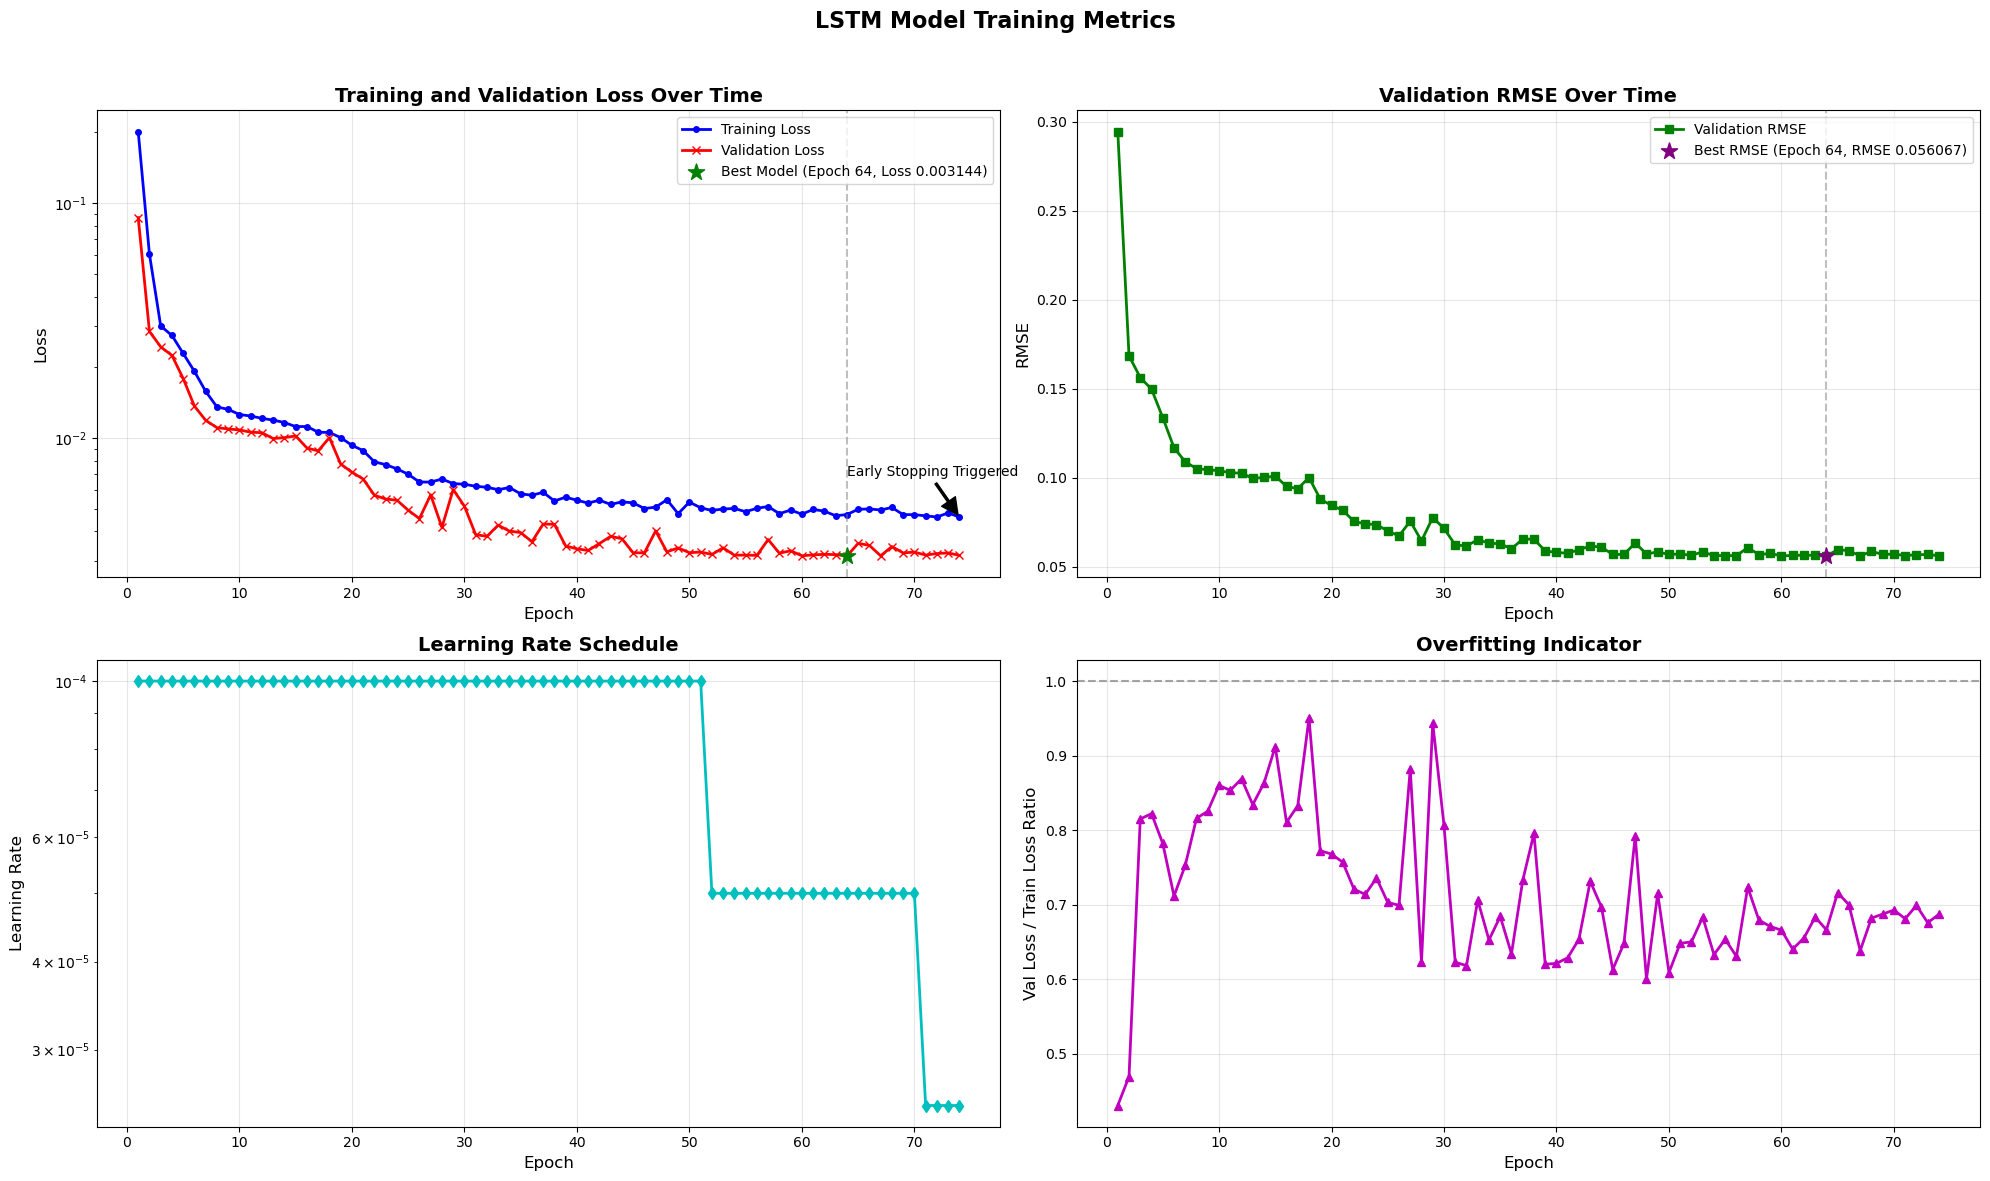

In [12]:
fig = model.plot_training_history()
plt.show()

In [13]:
predictions, actuals = model.evaluate(X_test, y_test, device=device)

Test RMSE: 0.053237


In [14]:
def create_evaluation_dashboard(predictions, actuals, scaler=None, country_names=None):
    """
    Create a comprehensive evaluation dashboard for time series predictions
    
    Args:
        predictions: Model predictions (numpy array)
        actuals: Actual values (numpy array)
        scaler: The scaler used to normalize the data (optional)
        country_names: List of country names if applicable (optional)
    """
    # If scaler is provided, inverse transform the data
    if scaler is not None:
        predictions = scaler.inverse_transform(predictions)
        actuals = scaler.inverse_transform(actuals)
    
    # Calculate metrics
    errors = actuals - predictions
    rmse = np.sqrt(np.mean(np.square(errors)))
    mae = np.mean(np.abs(errors))
    mape = np.mean(np.abs(errors / actuals)) * 100  # Mean Absolute Percentage Error
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 15))
    gs = fig.add_gridspec(3, 2)
    
    # 1. Actual vs Predicted Line Plot
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(actuals, label='Actual', color='blue')
    ax1.plot(predictions, label='Predicted', color='red', linestyle='--')
    ax1.set_title('Actual vs Predicted Values')
    ax1.set_xlabel('Data Point')
    ax1.set_ylabel('Value')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Scatter Plot
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.scatter(actuals, predictions, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(np.min(actuals), np.min(predictions))
    max_val = max(np.max(actuals), np.max(predictions))
    ax2.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    ax2.set_title('Actual vs Predicted Scatter')
    ax2.set_xlabel('Actual')
    ax2.set_ylabel('Predicted')
    ax2.grid(True)
    
    # Add correlation coefficient
    correlation = np.corrcoef(actuals.flatten(), predictions.flatten())[0, 1]
    ax2.text(0.05, 0.95, f'Correlation: {correlation:.4f}', 
             transform=ax2.transAxes, fontsize=10,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3. Error Histogram
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(errors, bins=30, alpha=0.7)
    ax3.axvline(x=0, color='r', linestyle='--')
    ax3.set_title('Error Distribution')
    ax3.set_xlabel('Error')
    ax3.set_ylabel('Frequency')
    ax3.grid(True)
    
    # 4. Residual Plot
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.scatter(predictions, errors, alpha=0.5)
    ax4.axhline(y=0, color='r', linestyle='--')
    ax4.set_title('Residual Plot')
    ax4.set_xlabel('Predicted')
    ax4.set_ylabel('Residual (Actual - Predicted)')
    ax4.grid(True)
    
    # 5. Metrics Table
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.axis('off')
    metrics_text = (
        f"Model Evaluation Metrics:\n\n"
        f"Root Mean Squared Error (RMSE): {rmse:.4f}\n"
        f"Mean Absolute Error (MAE): {mae:.4f}\n"
        f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%\n"
        f"Correlation Coefficient: {correlation:.4f}\n"
    )
    ax5.text(0.1, 0.5, metrics_text, fontsize=12, va='center')
    
    plt.tight_layout()
    plt.show()
    
    return fig




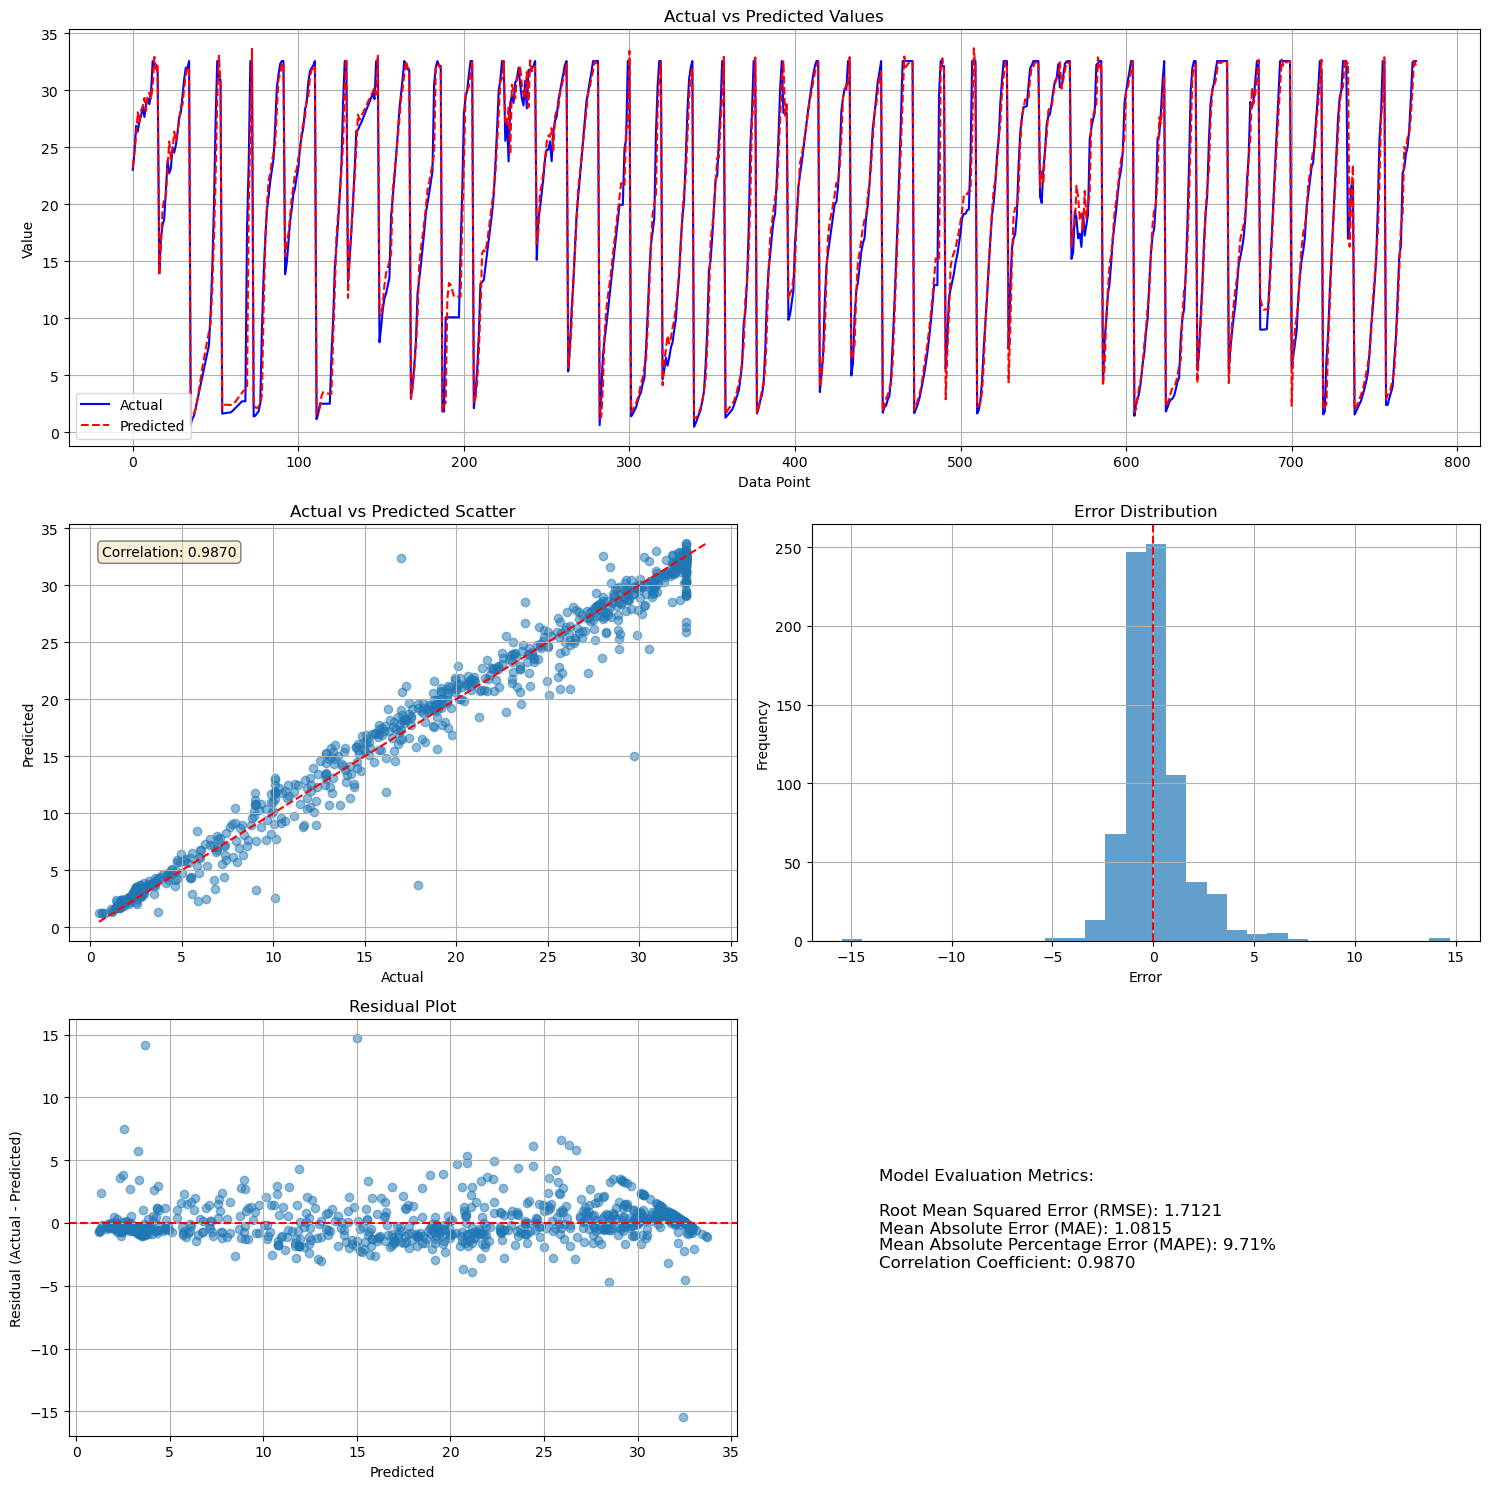

In [15]:

# Use the function with your predictions and actuals
fig = create_evaluation_dashboard(
    predictions, 
    actuals, 
    scaler  # Pass your scaler if you want to convert back to original scale
)

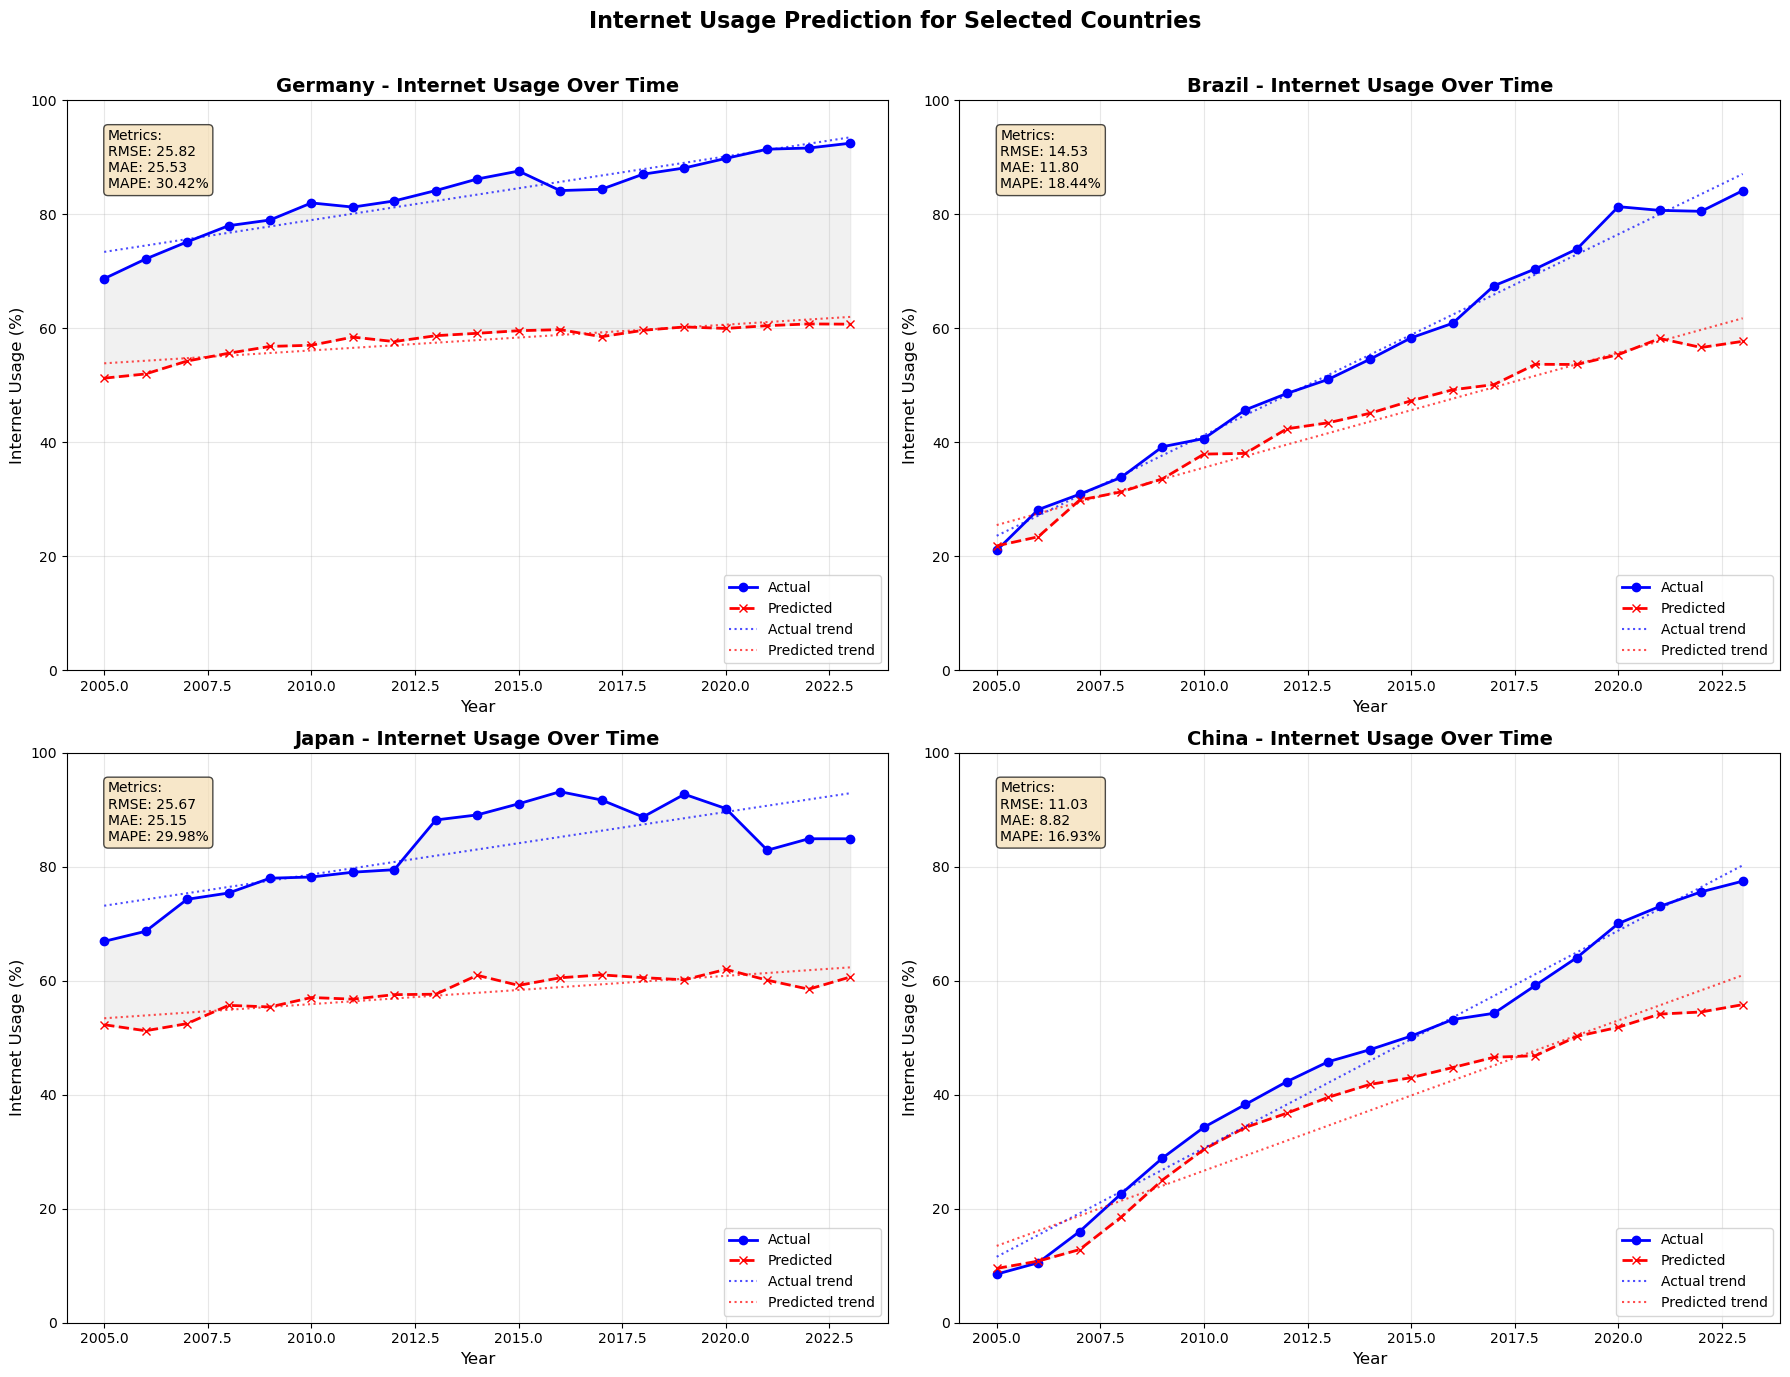

Overall Metrics by Country:
Germany:
  RMSE: 25.8185
  MAE: 25.5324
  MAPE: 30.4207
Brazil:
  RMSE: 14.5349
  MAE: 11.8038
  MAPE: 18.4362
Japan:
  RMSE: 25.6749
  MAE: 25.1534
  MAPE: 29.9785
China:
  RMSE: 11.0278
  MAE: 8.8235
  MAPE: 16.9291


In [16]:
def plot_detailed_country_predictions(model, countries_list, time_series_df, scaler, window_size=5, device='cpu'):
    """
    Create detailed plots for specific countries with actual vs predicted values
    with a fixed y-axis from 0 to 100% for easier comparison
    
    Args:
        model: Trained LSTM model
        countries_list: List of countries to plot ['Germany', 'USA', 'Japan', 'China']
        time_series_df: Original time series dataframe with countries as columns
        scaler: The scaler used to normalize the data
        window_size: The window size used for prediction
        device: Device to run predictions on ('cpu' or 'cuda')
    """
    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    # Get years
    years = time_series_df.index.tolist()
    prediction_years = years[window_size:]
    
    # Metrics dictionary to store results
    metrics = {}
    
    # For each country
    for i, country in enumerate(countries_list):
        if country not in time_series_df.columns:
            axes[i].text(0.5, 0.5, f"{country} data not found", 
                        horizontalalignment='center', verticalalignment='center')
            axes[i].set_title(country)
            # Set fixed y-axis even for empty plots
            axes[i].set_ylim(0, 100)
            continue
            
        # Get country data
        country_data = time_series_df[country].values
        
        # Handle NaN values
        country_data = pd.Series(country_data).fillna(method='ffill').fillna(method='bfill').values
        
        # Scale the data
        country_data_scaled = scaler.transform(country_data.reshape(-1, 1))
        
        # Create sequences
        X, y = [], []
        for j in range(len(country_data_scaled) - window_size):
            X.append(country_data_scaled[j:j+window_size])
            y.append(country_data_scaled[j+window_size])
            
        X = np.array(X)
        y = np.array(y)
        
        # Reshape for LSTM
        X = X.reshape(X.shape[0], X.shape[1], 1)
        
        # Get predictions
        country_predictions = model.predict(X, device=device)
        
        # Inverse transform
        y_actual = scaler.inverse_transform(y)
        y_pred = scaler.inverse_transform(country_predictions)
        
        # Calculate metrics
        errors = y_actual - y_pred
        rmse = np.sqrt(np.mean(np.square(errors)))
        mae = np.mean(np.abs(errors))
        mape = np.mean(np.abs(errors / (y_actual + 1e-10))) * 100  # Adding small value to avoid division by zero
        
        metrics[country] = {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape
        }
        
        # Plotting
        ax = axes[i]
        
        # Plot actual vs predicted
        ax.plot(prediction_years, y_actual, 'b-', label='Actual', linewidth=2, marker='o')
        ax.plot(prediction_years, y_pred, 'r--', label='Predicted', linewidth=2, marker='x')
        
        # Shade the area between
        ax.fill_between(prediction_years, y_actual.flatten(), y_pred.flatten(), 
                        color='lightgray', alpha=0.3)
        
        # Add trend lines
        try:
            z_actual = np.polyfit(range(len(prediction_years)), y_actual.flatten(), 1)
            p_actual = np.poly1d(z_actual)
            
            z_pred = np.polyfit(range(len(prediction_years)), y_pred.flatten(), 1)
            p_pred = np.poly1d(z_pred)
            
            ax.plot(prediction_years, p_actual(range(len(prediction_years))), 
                    'b:', label='Actual trend', alpha=0.7)
            ax.plot(prediction_years, p_pred(range(len(prediction_years))), 
                    'r:', label='Predicted trend', alpha=0.7)
        except:
            pass  # Skip trend lines if they can't be calculated
        
        # Set y-axis limits to fixed range from 0 to 100
        ax.set_ylim(0, 100)
        
        # Add horizontal grid lines at 20% intervals for better readability
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        
        # Formatting
        ax.set_title(f'{country} - Internet Usage Over Time', fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel('Internet Usage (%)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right')
        
        # Add metrics text box
        metrics_text = (
            f"Metrics:\n"
            f"RMSE: {rmse:.2f}\n"
            f"MAE: {mae:.2f}\n"
            f"MAPE: {mape:.2f}%"
        )
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
    
    # Add a title for the entire figure
    plt.suptitle('Internet Usage Prediction for Selected Countries', fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for the suptitle
    plt.show()
    
    # Print overall metrics
    print("Overall Metrics by Country:")
    for country, country_metrics in metrics.items():
        print(f"{country}:")
        for metric_name, value in country_metrics.items():
            print(f"  {metric_name}: {value:.4f}")
    
    return fig, metrics

# Use the function
countries_to_plot = ['Germany', 'Brazil', 'Japan', 'China']
fig, metrics = plot_detailed_country_predictions(
    model,  # Your trained LSTM model
    countries_to_plot,
    time_series_df,  # Your time series dataframe
    scaler,          # Your scaler
    window_size=5,   # Window size used for prediction
    device=device    # Device used for model
)

# Optionally save the figure
# fig.savefig('detailed_country_predictions.png', dpi=300, bbox_inches='tight')

## Stacked lstm

In [19]:
import stacked_lstm as sl


# 1. Prepare the data
X_train, X_val, y_train, y_val, scaler = sl.prepare_country_data(
    time_series_df,
    target_country='Germany',  # Country you want to predict
    n_steps=5,                 # Number of time steps to use as input
    test_size=0.2              # 20% of data for validation
)


In [21]:

# 2. Define model parameters
input_size = X_train.shape[2]   # Number of countries (features)
hidden_size = 248               # Hidden layer size
output_size = 1                 # Single target country
num_layers = 2                  # Number of LSTM layers

# 3. Create and train model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = sl.StackedLSTM(input_size, hidden_size, output_size, num_layers)

model.fit(
    X_train, y_train,
    X_val, y_val,
    epochs=100,
    batch_size=32,
    learning_rate=0.001,
    patience=15,
    device=device
)



X_train shape: (15, 5, 204), y_train shape: (15,)
X_val shape: (4, 5, 204), y_val shape: (4,)
Epoch 1/100 - Train loss: 0.612678 - Val loss: 0.665574 - Val RMSE: 0.815827
New best model saved with validation loss: 0.665574
Epoch 2/100 - Train loss: 0.490573 - Val loss: 0.433717 - Val RMSE: 0.658572
New best model saved with validation loss: 0.433717
Epoch 3/100 - Train loss: 0.361759 - Val loss: 0.171176 - Val RMSE: 0.413734
New best model saved with validation loss: 0.171176
Epoch 4/100 - Train loss: 0.200882 - Val loss: 0.000718 - Val RMSE: 0.026797
New best model saved with validation loss: 0.000718
Epoch 5/100 - Train loss: 0.060436 - Val loss: 0.250219 - Val RMSE: 0.500219
Epoch 6/100 - Train loss: 0.096034 - Val loss: 0.263028 - Val RMSE: 0.512862
Epoch 7/100 - Train loss: 0.111051 - Val loss: 0.099583 - Val RMSE: 0.315568
Epoch 8/100 - Train loss: 0.052879 - Val loss: 0.008849 - Val RMSE: 0.094069
Epoch 9/100 - Train loss: 0.010799 - Val loss: 0.005163 - Val RMSE: 0.071851
Epoch

StackedLSTM(
  (lstm1): LSTM(204, 248, batch_first=True)
  (lstm2): LSTM(248, 248, batch_first=True)
  (dense1): Linear(in_features=248, out_features=124, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (dense2): Linear(in_features=124, out_features=1, bias=True)
)

Training Summary:
Total Epochs: 38/75
Best Validation Loss: 0.000140 (Epoch 23)
Best Validation RMSE: 0.011817 (Epoch 23)
Final Training Loss: 0.009722
Final Validation Loss: 0.011121
Final Validation RMSE: 0.105455


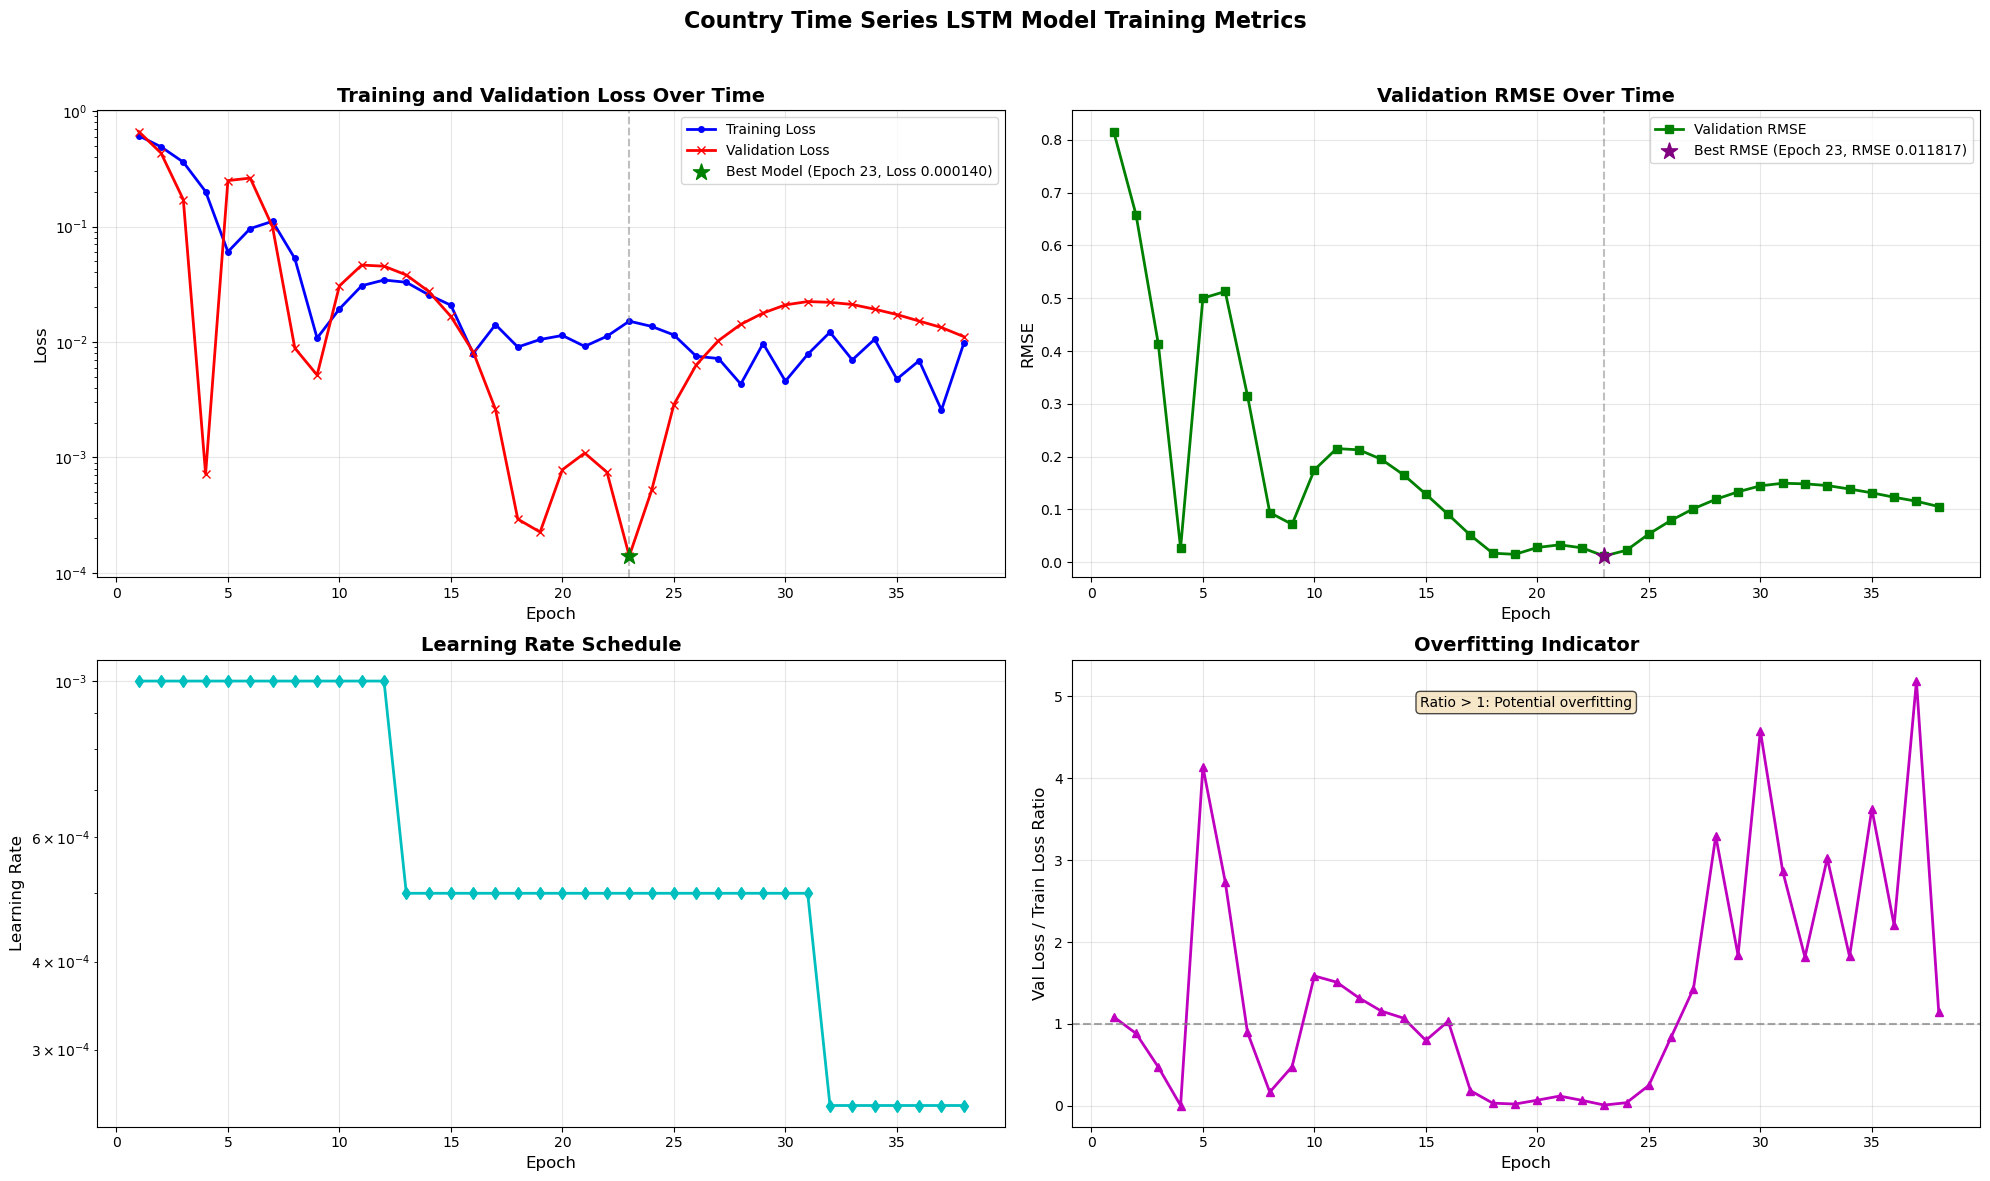

In [22]:

# 4. Plot training progress
fig = model.plot_training_history()
plt.show()



In [30]:
# 5. Make predictions on validation data
val_predictions = model.predict(X_val, device=device)

# 6. Inverse transform predictions to original scale
val_pred_reshaped = np.zeros((val_predictions.shape[0], X_train.shape[2]))
val_pred_reshaped[:, 0] = val_predictions.flatten()  # Put predictions in first column
val_pred_original = scaler.inverse_transform(val_pred_reshaped)[:, 0]  # Get first column

# 7. Inverse transform actual values
y_val_reshaped = np.zeros((y_val.shape[0], X_train.shape[2]))
y_val_reshaped[:, 0] = y_val  # Put actual values in first column
y_val_original = scaler.inverse_transform(y_val_reshaped)[:, 0]  # Get first colum



In [41]:
def run_internet_usage_prediction(time_series_df, countries_to_analyze, n_steps=5):
    """
    Train LSTM models and make predictions for multiple countries
    
    Args:
        time_series_df: DataFrame with countries as columns and years as index
        countries_to_analyze: List of countries to analyze
        n_steps: Number of time steps for input sequences
        
    Returns:
        predictions: Dictionary of predictions for each country
        actual_values: Dictionary of actual values for each country
    """
    predictions = {}
    actual_values = {}
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Process each country
    for country in countries_to_analyze:
        print(f"\n{'='*50}")
        print(f"Training model for {country}")
        print(f"{'='*50}")
        
        try:
            # Prepare data
            X_train, X_val, y_train, y_val, scaler = sl.prepare_country_data(
                time_series_df,
                target_country=country,
                n_steps=n_steps,
                test_size=0.2
            )
            
            # Define model parameters
            input_size = X_train.shape[2]   # Number of countries (features)
            hidden_size = 248                # Hidden layer size
            output_size = 1                 # Single target country
            
            # Create and train model
            model = sl.StackedLSTM(input_size, hidden_size, output_size)
            
            model.fit(
                X_train, y_train,
                X_val, y_val,
                epochs=100,
                batch_size=32,
                learning_rate=0.001,
                patience=15,
                device=device
            )
            
            # Plot and save training history
            fig_train = model.plot_training_history()
            plt.savefig(f"{country}_training_history.png", dpi=300, bbox_inches='tight')
            plt.close(fig_train)
            
            # Make predictions on validation data
            val_predictions = model.predict(X_val, device=device)
            
            # Inverse transform predictions
            val_pred_reshaped = np.zeros((val_predictions.shape[0], X_train.shape[2]))
            val_pred_reshaped[:, 0] = val_predictions.flatten()
            val_pred_original = scaler.inverse_transform(val_pred_reshaped)[:, 0]
            
            # Inverse transform actual values
            y_val_reshaped = np.zeros((y_val.shape[0], X_train.shape[2]))
            y_val_reshaped[:, 0] = y_val
            y_val_original = scaler.inverse_transform(y_val_reshaped)[:, 0]
            
            # Store results
            predictions[country] = val_pred_original
            actual_values[country] = y_val_original
            
            # Save model
            model.save(f"{country}_model.pt")
            
            # Calculate and print metrics
            from sklearn.metrics import mean_squared_error, mean_absolute_error
            rmse = np.sqrt(mean_squared_error(y_val_original, val_pred_original))
            mae = mean_absolute_error(y_val_original, val_pred_original)
            mape = np.mean(np.abs((y_val_original - val_pred_original) / (y_val_original + 1e-10))) * 100
            
            print(f"\nPerformance metrics for {country}:")
            print(f"RMSE: {rmse:.4f}")
            print(f"MAE: {mae:.4f}")
            print(f"MAPE: {mape:.4f}%")
            
        except Exception as e:
            print(f"Error processing {country}: {str(e)}")
            continue
    
    return predictions, actual_values

def create_combined_plot(predictions, actual_values, countries):
    """
    Create a combined plot of predictions vs actual values for multiple countries
    """
    # Create a figure with subplots for each country
    n_countries = len(countries)
    n_rows = (n_countries + 1) // 2  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(18, 6*n_rows))
    axes = axes.flatten()
    
    # For each country
    for i, country in enumerate(countries):
        if country not in predictions:
            continue
            
        ax = axes[i]
        
        # Get data
        pred = predictions[country]
        actual = actual_values[country]
        years = np.arange(len(actual))  # Or use actual years if available
        
        # Plot actual vs predicted
        ax.plot(years, actual, 'b-', label='Actual', linewidth=2, marker='o')
        ax.plot(years, pred, 'r--', label='Predicted', linewidth=2, marker='x')
        
        # Shade the area between
        ax.fill_between(years, actual, pred, color='lightgray', alpha=0.3)
        
        # Set y-axis to fixed range from 0 to 100 for percentage
        ax.set_ylim(0, 100)
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        
        # Formatting
        ax.set_title(f'{country} - Internet Usage Over Time', fontsize=14, fontweight='bold')
        ax.set_xlabel('Time Step', fontsize=12)
        ax.set_ylabel('Internet Usage (%)', fontsize=12)
        ax.grid(True, alpha=0.3)
        ax.legend(loc='lower right')
        
        # Add metrics text box
        try:
            rmse = np.sqrt(np.mean(np.square(actual - pred)))
            mae = np.mean(np.abs(actual - pred))
            mape = np.mean(np.abs((actual - pred) / (actual + 1e-10))) * 100
            
            metrics_text = (
                f"Metrics:\n"
                f"RMSE: {rmse:.2f}\n"
                f"MAE: {mae:.2f}\n"
                f"MAPE: {mape:.2f}%"
            )
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
            ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, fontsize=10,
                    verticalalignment='top', bbox=props)
        except:
            pass
    
    # Remove any unused subplots
    for i in range(len(countries), len(axes)):
        fig.delaxes(axes[i])
    
    # Add a title for the entire figure
    plt.suptitle('Internet Usage Prediction for Selected Countries', fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.savefig('combined_country_predictions.png', dpi=300, bbox_inches='tight')
    
    return fig

Using device: cpu

Training model for Germany
X_train shape: (11, 10, 204), y_train shape: (11,)
X_val shape: (3, 10, 204), y_val shape: (3,)
Epoch 1/100 - Train loss: 0.731663 - Val loss: 0.738517 - Val RMSE: 0.859370
New best model saved with validation loss: 0.738517
Epoch 2/100 - Train loss: 0.594332 - Val loss: 0.540487 - Val RMSE: 0.735178
New best model saved with validation loss: 0.540487
Epoch 3/100 - Train loss: 0.468580 - Val loss: 0.281369 - Val RMSE: 0.530442
New best model saved with validation loss: 0.281369
Epoch 4/100 - Train loss: 0.272042 - Val loss: 0.043410 - Val RMSE: 0.208351
New best model saved with validation loss: 0.043410
Epoch 5/100 - Train loss: 0.092067 - Val loss: 0.051569 - Val RMSE: 0.227088
Epoch 6/100 - Train loss: 0.057585 - Val loss: 0.103460 - Val RMSE: 0.321653
Epoch 7/100 - Train loss: 0.050619 - Val loss: 0.061927 - Val RMSE: 0.248852
Epoch 8/100 - Train loss: 0.071790 - Val loss: 0.006896 - Val RMSE: 0.083043
New best model saved with validati

/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 13/100 - Train loss: 0.028937 - Val loss: 0.044667 - Val RMSE: 0.211346
Epoch 14/100 - Train loss: 0.020580 - Val loss: 0.029232 - Val RMSE: 0.170975
Epoch 15/100 - Train loss: 0.012824 - Val loss: 0.014476 - Val RMSE: 0.120315
Epoch 16/100 - Train loss: 0.024867 - Val loss: 0.004047 - Val RMSE: 0.063612
New best model saved with validation loss: 0.004047
Epoch 17/100 - Train loss: 0.012297 - Val loss: 0.000565 - Val RMSE: 0.023769
New best model saved with validation loss: 0.000565
Epoch 18/100 - Train loss: 0.010542 - Val loss: 0.000030 - Val RMSE: 0.005477
New best model saved with validation loss: 0.000030
Epoch 19/100 - Train loss: 0.016462 - Val loss: 0.000196 - Val RMSE: 0.014005
Epoch 20/100 - Train loss: 0.022489 - Val loss: 0.000029 - Val RMSE: 0.005409
New best model saved with validation loss: 0.000029
Epoch 21/100 - Train loss: 0.016657 - Val loss: 0.000909 - Val RMSE: 0.030151
Epoch 22/100 - Train loss: 0.014806 - Val loss: 0.004087 - Val RMSE: 0.063930
Epoch 23/100

/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 11/100 - Train loss: 0.063231 - Val loss: 0.146452 - Val RMSE: 0.382691
Epoch 12/100 - Train loss: 0.049998 - Val loss: 0.126460 - Val RMSE: 0.355612
Epoch 00012: reducing learning rate of group 0 to 5.0000e-04.
Epoch 13/100 - Train loss: 0.038792 - Val loss: 0.110311 - Val RMSE: 0.332131
Epoch 14/100 - Train loss: 0.030987 - Val loss: 0.091220 - Val RMSE: 0.302026
Epoch 15/100 - Train loss: 0.027360 - Val loss: 0.070745 - Val RMSE: 0.265979
Epoch 16/100 - Train loss: 0.012820 - Val loss: 0.051865 - Val RMSE: 0.227740
Epoch 17/100 - Train loss: 0.021859 - Val loss: 0.034952 - Val RMSE: 0.186956
Epoch 18/100 - Train loss: 0.010186 - Val loss: 0.021805 - Val RMSE: 0.147664
Epoch 19/100 - Train loss: 0.011937 - Val loss: 0.012058 - Val RMSE: 0.109808
Early stopping triggered after 19 epochs
Training complete. Best model saved.
Training Summary:
Total Epochs: 19/75
Best Validation Loss: 0.000606 (Epoch 4)
Best Validation RMSE: 0.024617 (Epoch 4)
Final Training Loss: 0.011937
Final Va

/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 15/100 - Train loss: 0.007329 - Val loss: 0.053154 - Val RMSE: 0.230551
Epoch 16/100 - Train loss: 0.019759 - Val loss: 0.067068 - Val RMSE: 0.258975
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.
Epoch 17/100 - Train loss: 0.027161 - Val loss: 0.064858 - Val RMSE: 0.254672
Epoch 18/100 - Train loss: 0.026310 - Val loss: 0.054807 - Val RMSE: 0.234108
Epoch 19/100 - Train loss: 0.023137 - Val loss: 0.040972 - Val RMSE: 0.202414
Epoch 20/100 - Train loss: 0.016719 - Val loss: 0.027045 - Val RMSE: 0.164455
Epoch 21/100 - Train loss: 0.004443 - Val loss: 0.016447 - Val RMSE: 0.128245
Epoch 22/100 - Train loss: 0.009565 - Val loss: 0.009553 - Val RMSE: 0.097742
Epoch 23/100 - Train loss: 0.007690 - Val loss: 0.004957 - Val RMSE: 0.070406
Early stopping triggered after 23 epochs
Training complete. Best model saved.
Training Summary:
Total Epochs: 23/75
Best Validation Loss: 0.000323 (Epoch 8)
Best Validation RMSE: 0.017985 (Epoch 8)
Final Training Loss: 0.007690
Final Va

/Users/tom/anaconda3/envs/torch-gpu-2/lib/python3.9/site-packages/torch/optim/optimizer.py:242: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch 16/100 - Train loss: 0.014306 - Val loss: 0.010047 - Val RMSE: 0.100235
Epoch 17/100 - Train loss: 0.028797 - Val loss: 0.012873 - Val RMSE: 0.113458
Epoch 18/100 - Train loss: 0.017197 - Val loss: 0.019230 - Val RMSE: 0.138674
Epoch 19/100 - Train loss: 0.016820 - Val loss: 0.029944 - Val RMSE: 0.173044
Epoch 20/100 - Train loss: 0.008971 - Val loss: 0.043513 - Val RMSE: 0.208597
Epoch 21/100 - Train loss: 0.008502 - Val loss: 0.057687 - Val RMSE: 0.240181
Early stopping triggered after 21 epochs
Training complete. Best model saved.
Training Summary:
Total Epochs: 21/75
Best Validation Loss: 0.003324 (Epoch 6)
Best Validation RMSE: 0.057657 (Epoch 6)
Final Training Loss: 0.008502
Final Validation Loss: 0.057687
Final Validation RMSE: 0.240181
Error processing China: 'StackedLSTM' object has no attribute 'save'


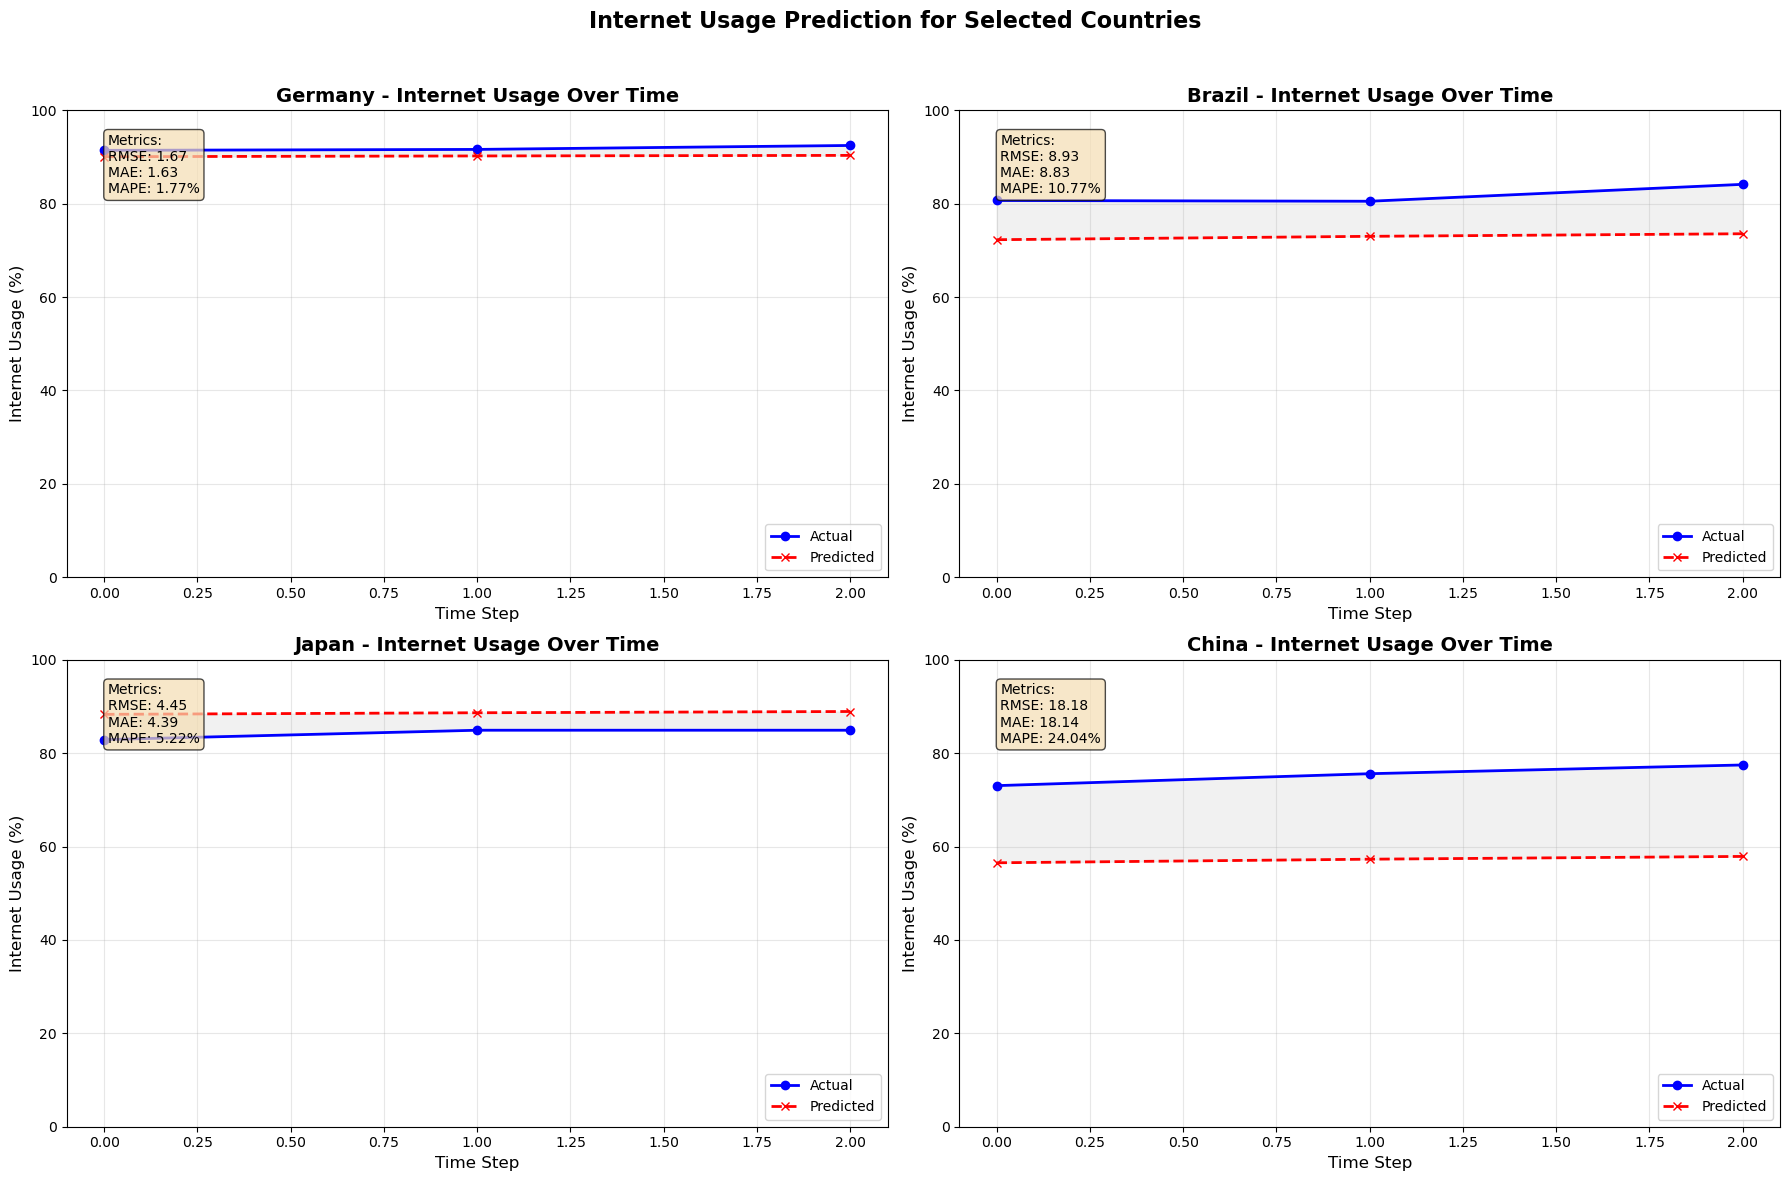

In [42]:
# Define countries to analyze
countries_to_analyze = ['Germany', 'Brazil', 'Japan', 'China']

# Run the training and prediction pipeline
predictions, actuals = run_internet_usage_prediction(
    time_series_df, 
    countries_to_analyze,
    n_steps=10
)

# Create combined visualization
fig = create_combined_plot(predictions, actuals, countries_to_analyze)

In [18]:
model.save('my_lstm_model.pt')
# loaded_model = LSTM.load('my_lstm_model.pt', device=device)

Model saved to my_lstm_model.pt
